In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plot_utils import cblind_cmap
from tqdm.notebook import tqdm
from metric_utils import ConfusionMatrixMetrics


PHASES = ["liquid", "ice", "mixed", "drizzle", "liq_driz", "rain", "snow"]
letter_labels = [f"({letter})" for letter in "abcdefghijklmnopqrstuvwxyz"]

cmap = cblind_cmap.copy()
cmap["avg"] = "black"

phases = [
    "liquid", 
    "ice", 
    "mixed", 
    "drizzle", 
    "liq_driz", 
    "rain", 
    "snow",
]
models = {
    "cnn": "CNN",
    "mlp": "MLP",
    "rf": "RF",
    # "avg": "Avg"
}

plt.style.use("style.mplstyle")

In [ ]:
df = pd.read_parquet("data/parallel_nsa_cloudy_predictions.parquet")
df = df.reset_index(drop=True)  # drop time & height; we'll be just be using 'cloud_phase'
df.head()

,cloud_phase,cnn_dropout,cnn,rf_balanced,rf_imbalanced,mlp_balanced,mlp_imbalanced,cnn_dropout_confidence,cnn_confidence,rf_balanced_confidence,...,mlp_imbalanced_mpl,mlp_imbalanced_mpl_b,mlp_imbalanced_mpl_ldr,mlp_imbalanced_mwr,mlp_imbalanced_rad,mlp_imbalanced_rad_ldr,mlp_imbalanced_rad_mdv,mlp_imbalanced_rad_ref,mlp_imbalanced_rad_spec,mlp_imbalanced_sonde
0,ice,ice,ice,liquid,ice,liquid,ice,0.864284,0.793064,0.55,...,liquid,liquid,liquid,liquid,ice,ice,ice,ice,ice,ice
1,ice,ice,ice,liquid,ice,ice,ice,0.920299,0.910763,0.52,...,ice,ice,ice,liquid,ice,ice,ice,ice,ice,ice
2,ice,ice,ice,ice,ice,ice,ice,0.859795,0.926132,0.55,...,ice,ice,ice,liquid,ice,ice,ice,ice,ice,ice
3,ice,ice,ice,liquid,ice,ice,ice,0.812101,0.895370,0.59,...,liquid,ice,ice,liquid,ice,ice,ice,ice,ice,ice
4,ice,ice,ice,ice,ice,liquid,ice,0.909938,0.861275,0.51,...,liquid,ice,liquid,liquid,ice,ice,ice,liquid,ice,ice


In [9]:
true_phase = df["cloud_phase"]
phase_idxs = {phase_label: np.where(true_phase == phase_label) for phase_label in phases}
phase_dfs = {phase_label: df.iloc[idxs] for phase_label, idxs in phase_idxs.items()}

In [22]:
models_to_compute = {
    "cnn": "cnn",
    "rf_balanced": "rf",
    "mlp_balanced": "mlp",
}
ablations = [
    "mpl",
    "rad",
    "mwr",
    "sonde"
]


recall_scores = {}
for phase in tqdm(PHASES):
    df_phase = phase_dfs[phase]
    phase_scores = {}

    for model, model_label in models_to_compute.items():
        model_baseline = (df_phase[model] == phase).mean()

        for ablation in ablations:
            ablated_col_name = f"{model}_{ablation}"
            ablated_label = f"{model_label}_{ablation}"
            ablated_score = (df_phase[ablated_col_name] == phase).mean()
            phase_scores[ablated_label] = model_baseline - ablated_score
    
    recall_scores[phase] = phase_scores

_scores_df = pd.DataFrame.from_dict(recall_scores, orient="index")
_scores_df

  0%|          | 0/7 [00:00<?, ?it/s]

,cnn_mpl,cnn_rad,cnn_mwr,cnn_sonde,rf_mpl,rf_rad,rf_mwr,rf_sonde,mlp_mpl,mlp_rad,mlp_mwr,mlp_sonde
liquid,0.413741,0.721420,-0.008714,0.606447,0.027468,0.890362,-0.012020,0.797269,0.043870,0.885727,-0.006400,0.790912
ice,-0.005930,-0.010710,0.006686,0.006776,-0.027037,-0.128901,0.038310,0.018682,-0.036654,-0.120580,0.035966,0.025606
mixed,0.234759,0.587630,-0.010623,-0.014339,0.089780,0.569708,-0.002771,-0.045216,0.089502,0.508017,-0.001125,-0.045047
drizzle,-0.109211,-0.100462,-0.001190,0.825552,0.049323,-0.136615,-0.039103,0.861573,0.058379,-0.049492,-0.057005,0.852627
liq_driz,0.155202,0.753021,-0.003771,0.816521,0.003567,0.848442,0.048546,0.900126,0.008877,0.747924,0.081049,0.905401
rain,0.067850,0.975574,-0.000271,0.912509,0.001528,0.973398,0.028132,0.973398,0.001199,0.961033,0.198927,0.961039
snow,-0.009879,0.937965,0.000280,0.000692,0.000686,0.973348,-0.001769,0.015168,-0.004483,0.975969,-0.001089,0.019749


In [30]:
_scores_melt = _scores_df.melt(var_name='model_feature', value_name='importance', ignore_index=False)
_scores_melt[['model', 'feature']] = _scores_melt['model_feature'].str.split('_', expand=True)
_scores_melt = _scores_melt.drop(columns=['model_feature'])
scores_df = _scores_melt[['feature', 'importance', 'model']].reset_index(names="phase")
scores_df


,phase,feature,importance,model
0,liquid,mpl,0.413741,cnn
1,ice,mpl,-0.005930,cnn
2,mixed,mpl,0.234759,cnn
3,drizzle,mpl,-0.109211,cnn
4,liq_driz,mpl,0.155202,cnn
...,...,...,...,...
79,mixed,sonde,-0.045047,mlp
80,drizzle,sonde,0.852627,mlp
81,liq_driz,sonde,0.905401,mlp
82,rain,sonde,0.961039,mlp


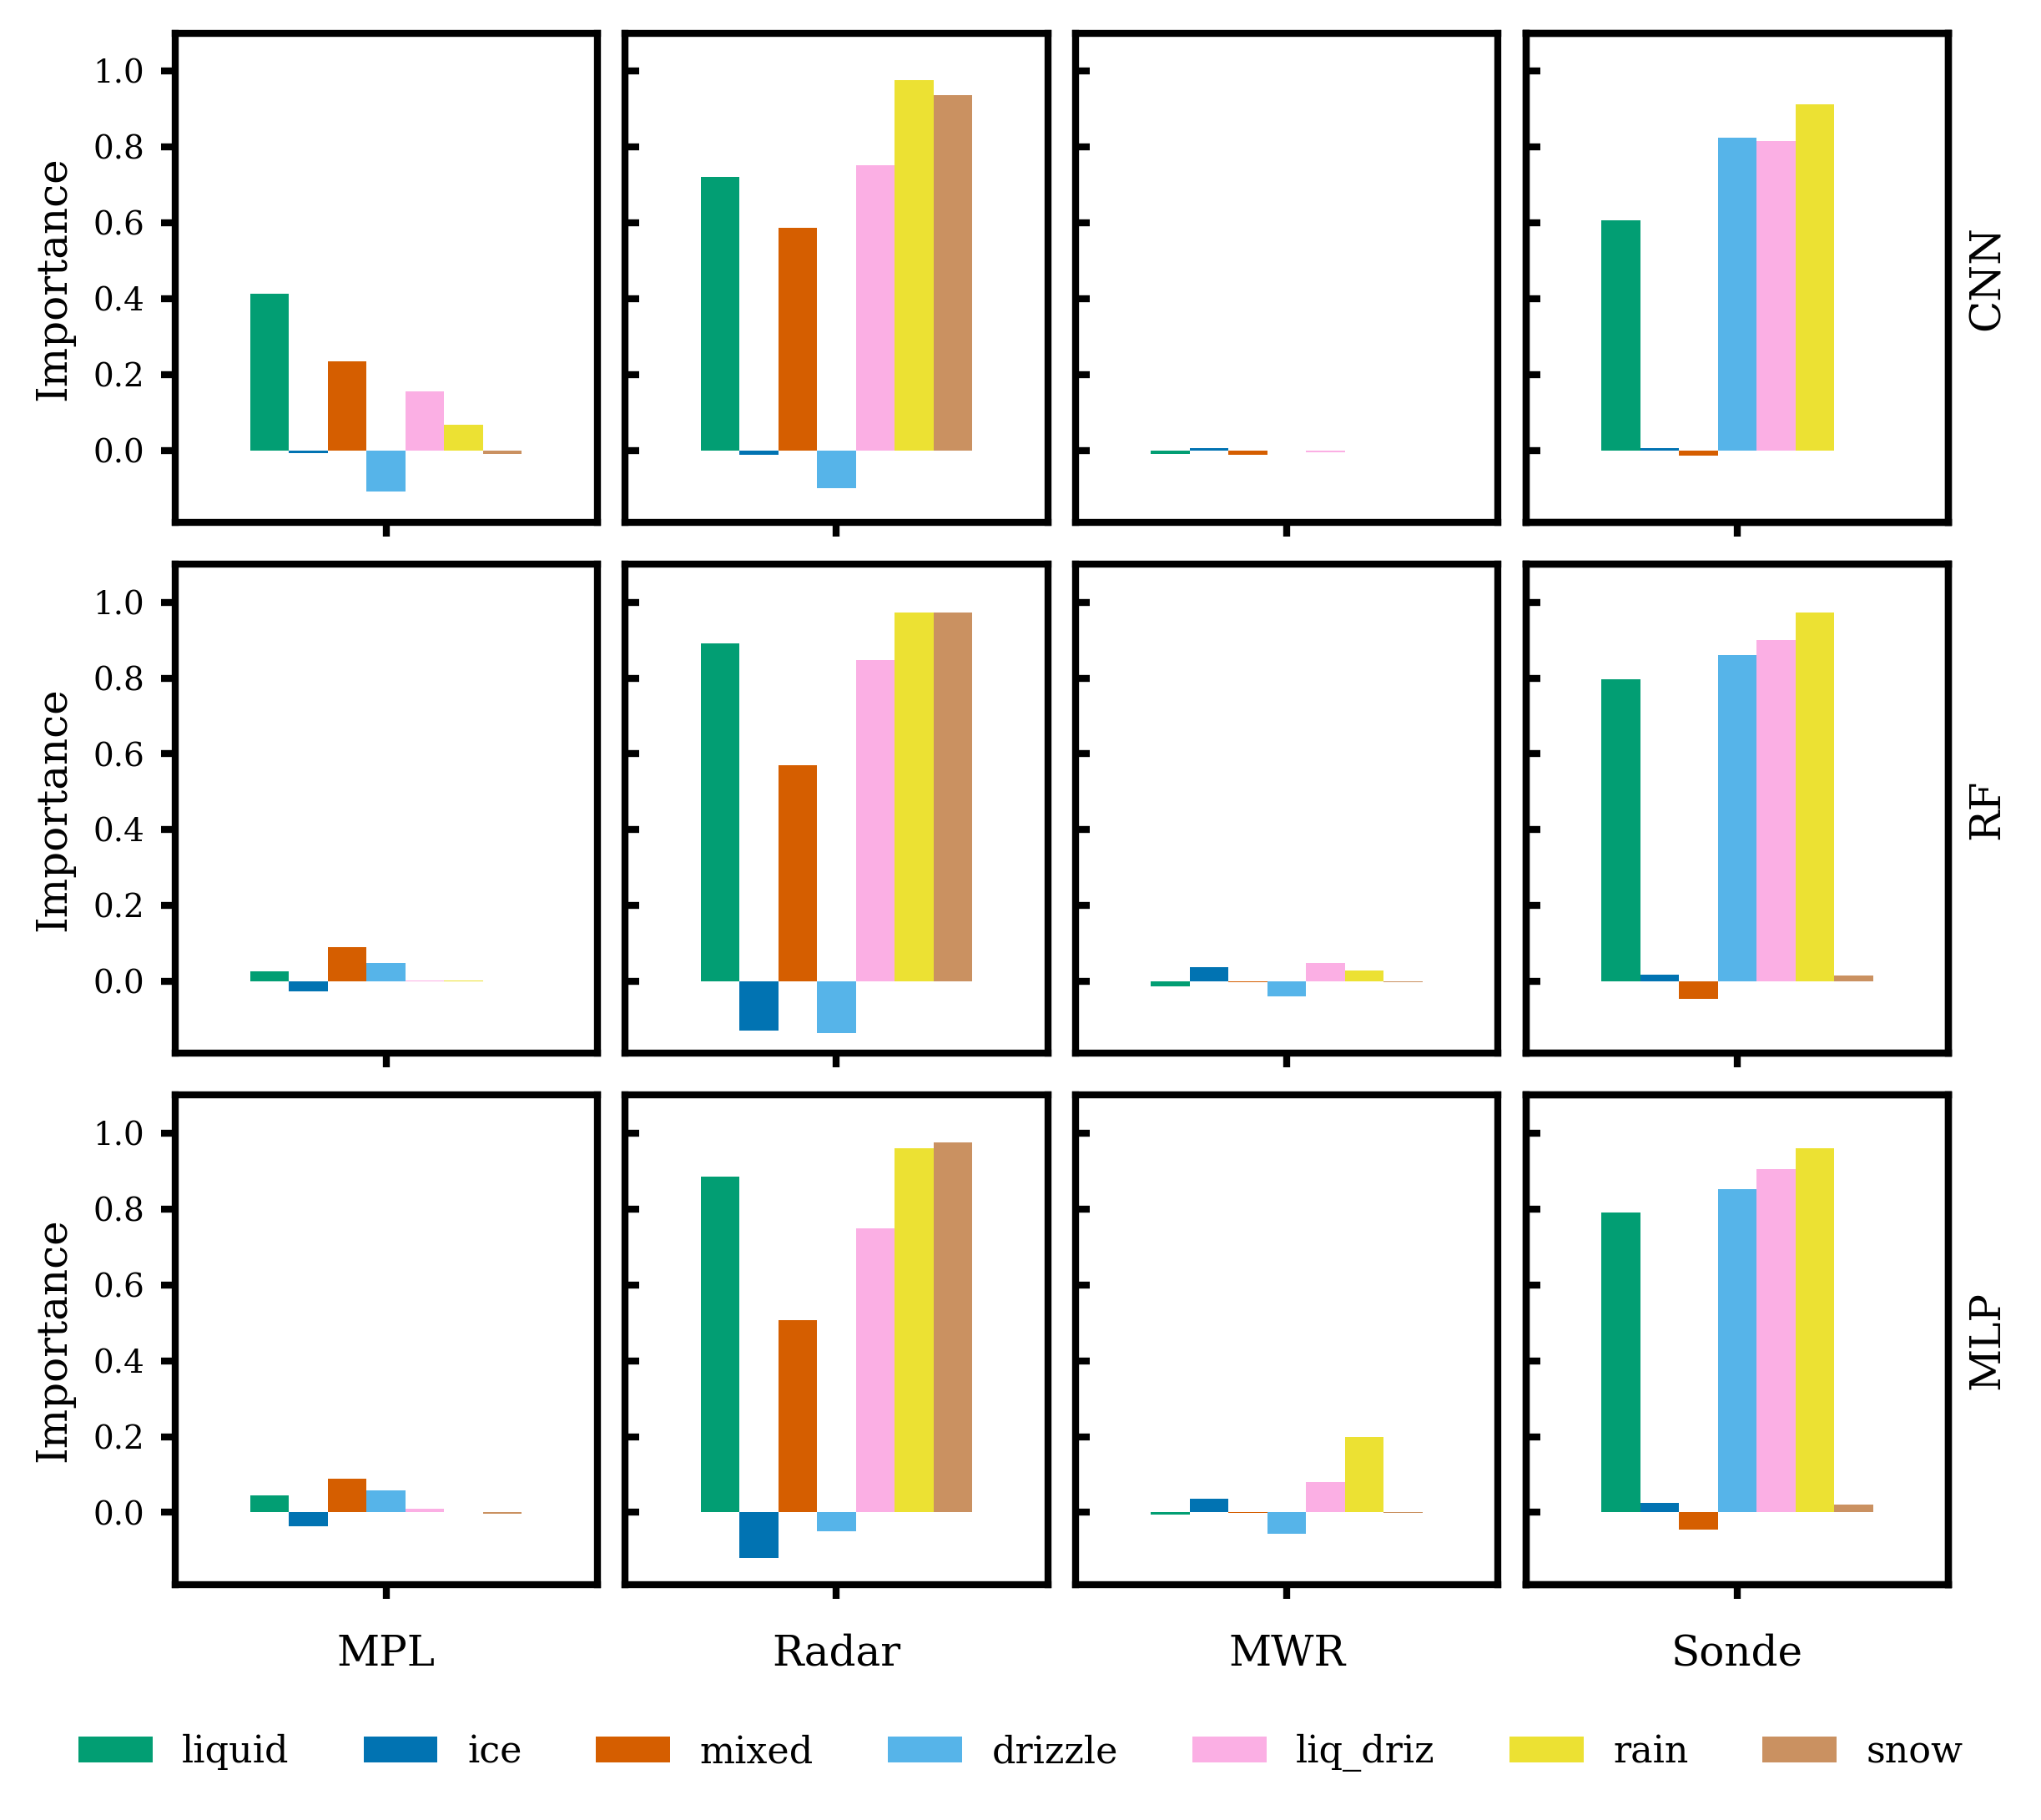

In [78]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(6,5), sharey=True, layout="constrained")
# fig, axs = plt.subplots(nrows=3, figsize=(6,5), sharex=True, layout="constrained")

min_importance = -0.19

groups = {
    "MPL": ["mpl"],
    "Radar": ["rad"],
    "MWR": ["mwr"],
    "Sonde": ["sonde"],
}

group_map = {
    "mpl": "MPL",
    "rad": "Radar",
    "mwr": "MWR",
    "sonde": "Sonde",
}

for i, model_label in enumerate(models_to_compute.values()):
    _model_data = scores_df[scores_df["model"] == model_label]
    data = _model_data.pivot(index="feature", columns="phase", values="importance")
    data = data[phases]

    # data.plot.bar(ax=axs[i], width=0.9, color=cblind_cmap, legend=None)

    # axs[i].set_ylabel("Ablation\nImportance")
    # axs[i].set_xlabel("")

    # if i != len(models_to_compute) - 1:
    #     axs[i].xaxis.set_ticklabels([])
    # else:
    #     axs[i].xaxis.set_ticklabels(
    #         [group_map[t.get_text()] for t in axs[i].xaxis.get_ticklabels()],
    #         rotation=0,
    #         fontsize=12
    #     )


    for j, (group_title, group_vars) in enumerate(groups.items()):
        ax = axs[i, j]
        group_data = data.loc[group_vars]
        group_data.plot.bar(ax=ax, width=0.9, color=cblind_cmap, legend=None)
        ax.set_ylim(min_importance, 1.1)
        ax.set_xlabel("")
        ax.set_ylabel("Importance")
        ax.xaxis.set_tick_params(rotation=0)

        # if i == 0:
        #     ax.set_title(group_title)

        if i != len(models) - 1:
            ax.xaxis.set_ticklabels([])
            # ax.xaxis.set_tick_params(direction="in")
        else:
            ax.xaxis.set_ticklabels([])
            ax.set_xlabel(group_title)

        if j != 0:
            ax.yaxis.set_tick_params(direction="in")

        if j == len(groups) - 1:
            y_twin = ax.twinx()
            y_twin.set_ylabel(model_label.upper())
            y_twin.set_yticks([], [])

# handles, labels = axs[-1].get_legend_handles_labels()
handles, labels = axs[-1, -1].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=7,
    bbox_to_anchor=(0.5, -0.07),
    fontsize=8,
)
fig.savefig("ablation_importance.png")
plt.show()

In [113]:
models_to_compute = {
    "cnn": "CNN",
    "cnn_dropout": "CNN (Dropout)",
    "rf_balanced": "RF",
    "mlp_balanced": "MLP",
}
ablations = [
    "mpl",
    "rad",
    "mwr",
    "sonde"
]


metrics = {}
for model in tqdm(models_to_compute):
    model_conf = ConfusionMatrixMetrics(pred=df[model], truth=true_phase).scores().to_dict()

    metrics[model + "_acc"] = model_conf["acc"]
    metrics[model + "_iou"] = model_conf["iou"]


    for suffix in ablations:
        ablated_col_name = f"{model}_{suffix}"

        ablated_scores = ConfusionMatrixMetrics(pred=df[ablated_col_name], truth=true_phase).scores().to_dict()

        metrics[ablated_col_name + "_acc"] = ablated_scores["acc"]
        metrics[ablated_col_name + "_iou"] = ablated_scores["iou"]

metrics

  0%|          | 0/4 [00:00<?, ?it/s]

{'cnn_acc': 0.9570036351396224,
 'cnn_iou': 0.810592055595083,
 'cnn_mpl_acc': 0.9098953779054855,
 'cnn_mpl_iou': 0.7140431204811405,
 'cnn_rad_acc': 0.7563014767183918,
 'cnn_rad_iou': 0.19900393154716564,
 'cnn_mwr_acc': 0.9538405971724015,
 'cnn_mwr_iou': 0.8065508463744476,
 'cnn_sonde_acc': 0.8807508396884067,
 'cnn_sonde_iou': 0.3658608214593302,
 'cnn_dropout_acc': 0.8839597417754568,
 'cnn_dropout_iou': 0.6224930767915293,
 'cnn_dropout_mpl_acc': 0.9019794741584716,
 'cnn_dropout_mpl_iou': 0.6682324043416052,
 'cnn_dropout_rad_acc': 0.7682162296425412,
 'cnn_dropout_rad_iou': 0.21925149081545595,
 'cnn_dropout_mwr_acc': 0.8850825810583249,
 'cnn_dropout_mwr_iou': 0.6252360130774164,
 'cnn_dropout_sonde_acc': 0.8853365894291582,
 'cnn_dropout_sonde_iou': 0.5565931780695801,
 'rf_balanced_acc': 0.8576707609505861,
 'rf_balanced_iou': 0.7147362958310602,
 'rf_balanced_mpl_acc': 0.8661444574081342,
 'rf_balanced_mpl_iou': 0.6994048178571102,
 'rf_balanced_rad_acc': 0.7279287278354

In [114]:
formatted_data = []
for k, v in metrics.items():
    if "dropout" in metrics:
        continue

    if "mlp" in k or "rf" in k:  # remove the 'balance' from 
        prefix = k.split("_")[0]  # either mlp or rf
        suffix = "_".join(k.split("_")[2:])
        k = f"{prefix}_{suffix}"

    parts = k.split('_')
    if len(parts) == 2:
        model = parts[0]
        metric = parts[1]
        instrument = 'control'
    else:  # len is 3
        model = parts[0]
        instrument = parts[1]
        metric = parts[2]
    formatted_data.append({'model': model, 'metric': metric, 'instrument': instrument, 'value': v})
metrics_df = pd.DataFrame(formatted_data)

instrument_order = ["control", "mpl", "rad", "mwr", "sonde"]
metrics_df['instrument'] = pd.Categorical(metrics_df['instrument'], categories=instrument_order, ordered=True)
metrics_df = metrics_df.sort_values('instrument')


metrics_df

,model,metric,instrument,value
0,cnn,acc,control,0.957004
1,cnn,iou,control,0.810592
31,mlp,iou,control,0.695153
30,mlp,acc,control,0.846454
20,rf,acc,control,0.857671
21,rf,iou,control,0.714736
2,cnn,acc,mpl,0.909895
3,cnn,iou,mpl,0.714043
33,mlp,iou,mpl,0.686407
32,mlp,acc,mpl,0.861007


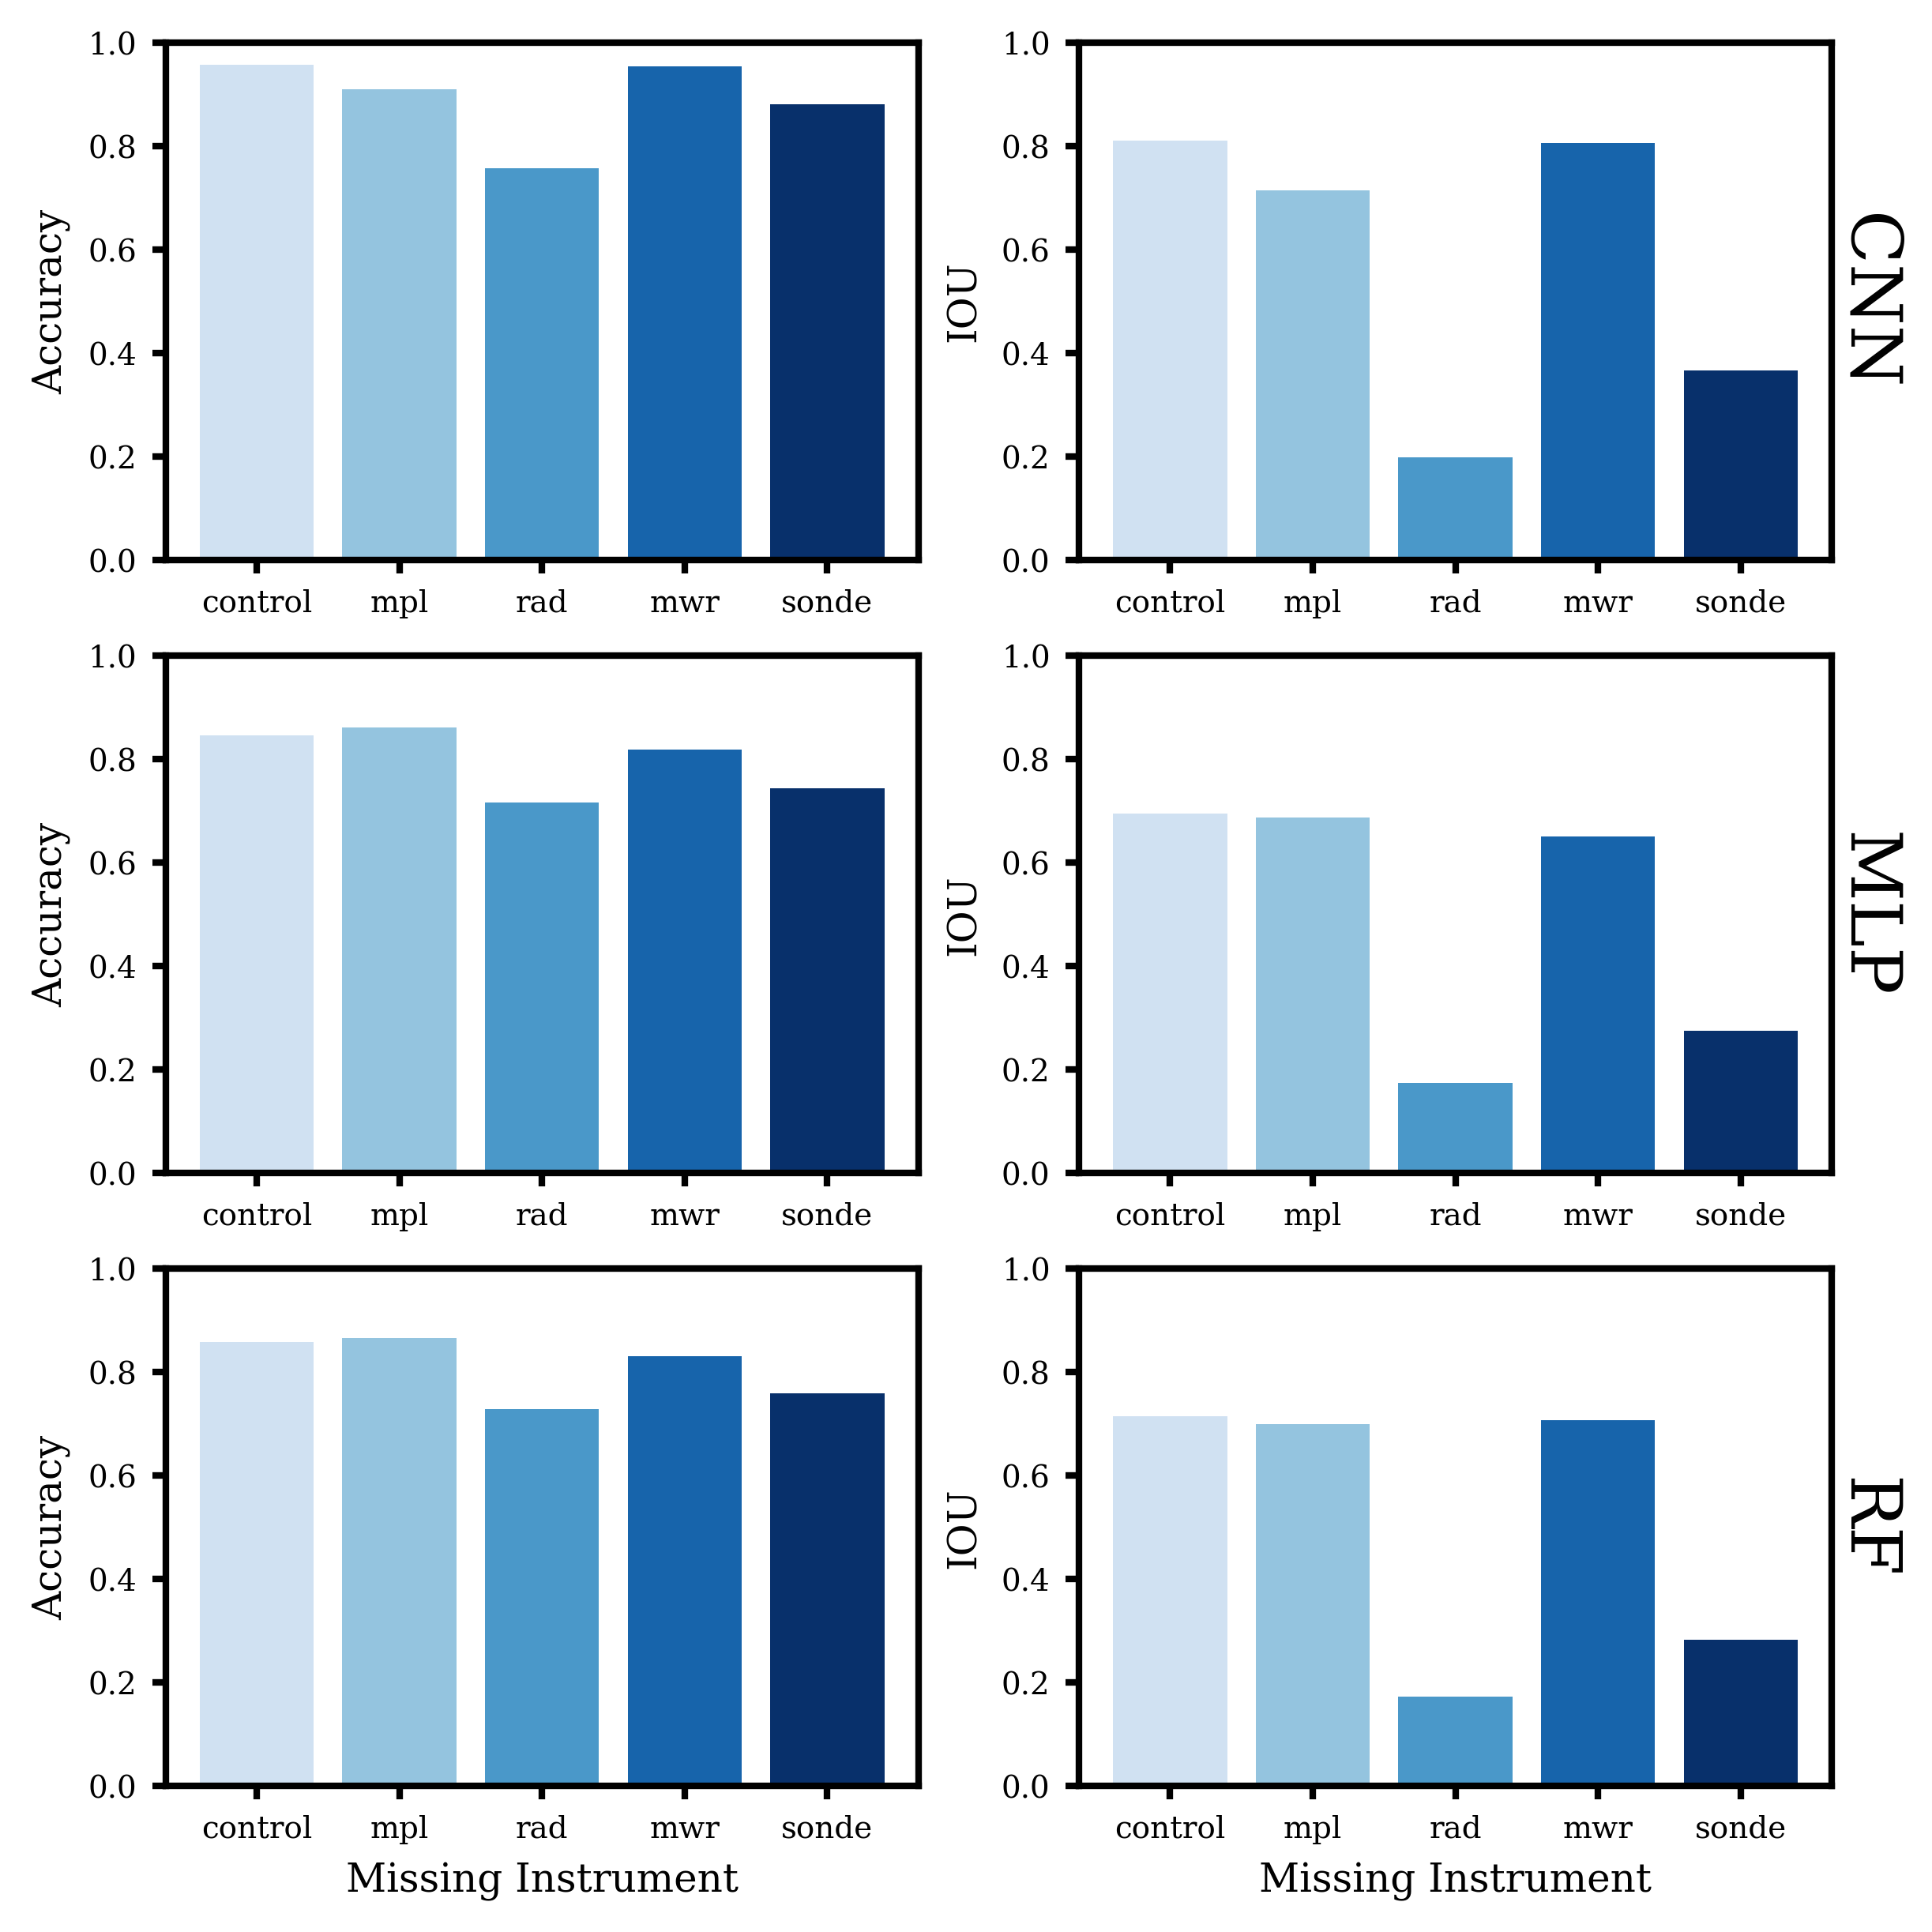

In [ ]:


# Creating a list of model names
models = ["cnn", "cnn_dropout", "mlp", "rf"]

# Creating the figure and the axes for subplots
fig, axs = plt.subplots(nrows=len(models), ncols=2, figsize=(6,6), constrained_layout=True)
# fig.suptitle('Model Performance by Instrument')

# Plotting each subplot
for i, model in enumerate(models):
    for j, metric in enumerate(['acc', 'iou']):
        data_subset = metrics_df[(metrics_df['model'] == model) & (metrics_df['metric'] == metric)]
        
        # Creating the bar plot
        bars = axs[i, j].bar(data_subset['instrument'], data_subset['value'], color=plt.cm.Blues([0.2, 0.4, 0.6, 0.8, 1.0]))
        
        # Adding titles and labels
        axs[i, j].set_title(f'{model.upper()} - {metric.upper()}')
        axs[i, j].set_xlabel('Missing Instrument' if i == 2 else "")
        axs[i, j].set_ylabel("Accuracy" if metric == "acc" else "IOU")
        axs[i, j].set_ylim(0, 1)
        axs[i, j].set_title("")

        if j == 1:
            axs[i, j].text(1, 0.5, model.upper(), rotation=-90, ha='left', va='center', transform=axs[i, j].transAxes, fontsize=16)

# Show plot
fig.savefig("ablation.png")

plt.show()


In [112]:
true_phase.value_counts(normalize=True)

ice         0.715436
mixed       0.093024
snow        0.086620
liquid      0.070247
rain        0.017499
drizzle     0.009639
liq_driz    0.007535
Name: cloud_phase, dtype: float64